# Interpretability increases with N<sub>h</sub>

### Imports

In [3]:
import os
import pandas as pd
from iqual import tests

> ### Load datasets

In [4]:
data_dir    = "../../data/"

### Enhanced qualitative data
bootstrap_df = pd.read_csv(os.path.join(data_dir,"enhanced_bootstrap_kfold.csv"))

### Quantitative data
quant_df      = pd.read_csv(os.path.join(data_dir,"quant_data.csv"))

> ### Variables

In [5]:
annotation_vars = [
     "ability_high",
     "ability_low",
     "awareness_information_high",
     "awareness_information_low",
     "budget_high",
     "budget_low",
     "covid_impacts",
     "education_high",
     "education_low",
     "education_neutral",
     "education_religious",
     "entrepreneur",
     "job_secular",
     "marriage",
     "migration",
     "no_ambition",
     "public_assistance",
     "reliance_on_god",
     "religious",
     "secular",
     "vague_job",
     "vague_non_specific",
     "vocational_training",
     "worries_anxieties",
    ]

id_vars    = ['uid','data_round','refugee','bootstrap_run','train_sample_size']

> ### Human Annotated Data (Merged with quantiative data)

In [6]:
human_df = bootstrap_df.loc[bootstrap_df.split=='train',[*id_vars,*annotation_vars]].copy()

human_df = human_df.rename(columns={c+"_act":c for c in annotation_vars}).drop_duplicates()
human_df = pd.merge(human_df,quant_df,on=['uid','data_round','refugee'],how='left')

> ### Enhanced Dataframe (Merged with quantiative data)

In [7]:
enhanced_df = bootstrap_df[[*id_vars,*annotation_vars]].copy()
enhanced_df = pd.merge(enhanced_df,quant_df,on=['uid','data_round','refugee'],how='left')

> ### Interpretability tests on Human Data

In [8]:
# Numerical regressors

numerical_vars = [
     'refugee','hh_head_sex','eld_sex','parent_reledu','data_round',
     'num_child',
     'hh_head_age',
     'parent_eduyears',
     'eld_age',
     'hh_asset_index',
     'hh_income',
     'int_trauma_exp',
]

> ## Human

In [ ]:
human_int_dfs = []

for (train_size, bootstrap_run), df_human in human_df.groupby(['train_sample_size','bootstrap_run']):
    
    interpreter = tests.Interpretability(df_human,
                                         annotation_vars=annotation_vars,
                                         numerical_regressors=numerical_vars,
                    ).fit_all()
    
    human_interp_df = interpreter.get_results()    
    
    human_interp_df['train_size']     = train_size
    human_interp_df['bootstrap_run']  = bootstrap_run
    human_int_dfs.append(human_interp_df)
    
human_interp_data = pd.concat(human_int_dfs,axis=0)    

> ## Enhanced

In [ ]:
enhanced_int_dfs = []
for (train_size, bootstrap_run), df_enh in bootstrap_df.groupby(['train_sample_size','bootstrap_run']):
    interpreter = tests.Interpretability(df_enh,
                                         annotation_vars=annotation_vars,
                                         numerical_regressors=numerical_vars,
                    ).fit_all()
    
    enhanced_interp_df = interpreter.get_results()    
    
    enhanced_interp_df['train_size']     = train_size
    enhanced_interp_df['bootstrap_run']  = bootstrap_run
    enhanced_int_dfs.append(enhanced_interp_df)
    
enhanced_interp_data = pd.concat(enhanced_int_dfs,axis=0)

### F-statistic test for interpretability increases with Nh (holding N fixed)

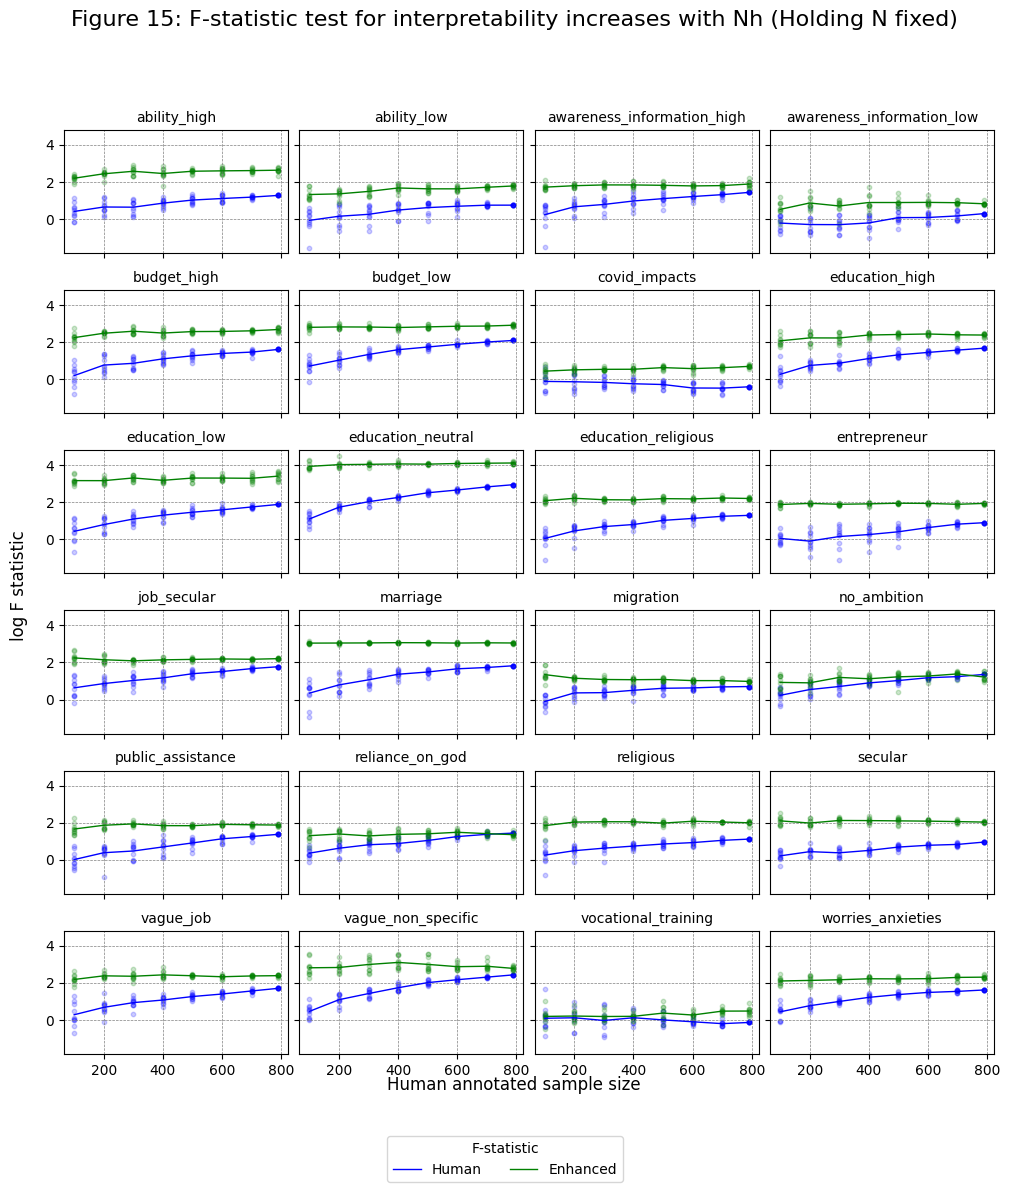

In [21]:
import matplotlib.pyplot as plt

nrows, ncols = 6, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12), 
                         sharex=True, sharey=True,                         
                        )
axes_flat = axes.ravel()

for a, annotation_var in enumerate(annotation_vars):
    
    ax = axes_flat[a]
    
    human_x = human_interp_data.loc[human_interp_data['annotation']==annotation_var,'train_size'].values
    human_y = human_interp_data.loc[human_interp_data['annotation']==annotation_var,'log_fstat'].values
    
    enh_x = enhanced_interp_data.loc[enhanced_interp_data['annotation']==annotation_var,'train_size'].values
    enh_y = enhanced_interp_data.loc[enhanced_interp_data['annotation']==annotation_var,'log_fstat'].values
    
    # Scatter plots
    ax.scatter(human_x,human_y, marker="o", color='blue', s=10, alpha=0.2,)
    ax.scatter(enh_x, enh_y, marker="o", color='green', s=10, alpha=0.2, )

    # Mean plots
    
    human_mean = human_interp_data.loc[human_interp_data['annotation']==annotation_var].groupby('train_size').mean(numeric_only=True)
    enh_mean   = enhanced_interp_data.loc[enhanced_interp_data['annotation']==annotation_var].groupby('train_size').mean(numeric_only=True)

    ax.plot(human_mean.index, human_mean['log_fstat'], color='blue', label='Human', lw=1)
    ax.plot(enh_mean.index, enh_mean['log_fstat'], color='green', label='Enhanced', lw=1)

    ax.set_title(annotation_var, fontsize=10)
    ax.grid(linewidth=0.5, color='gray', linestyle='--')

fig.text(0.5, 0.08, 'Human annotated sample size', ha='center', fontsize=12)
fig.text(0.08, 0.5, 'log F statistic', va='center', rotation='vertical', fontsize=12)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,title='F-statistic', loc='lower center', ncol=2)

fig.suptitle("Figure 15: F-statistic test for interpretability increases with Nh (Holding N fixed)", fontsize=16, )
fig.subplots_adjust(hspace=0.3, wspace=0.05, )

plt.show()